In [9]:
import os
import shutil

src_base = "drawings"
dst_base = "drawings_separated"

# Define classes
classes = ["spiral_healthy", "spiral_parkinson", "wave_healthy", "wave_parkinson"]

# Create final dirs for train and test
for split in ["train", "test"]:
    for cls in classes:
        os.makedirs(os.path.join(dst_base, split, cls), exist_ok=True)

def copy_files(src_dirs, dst_base, split):
    for src_dir in src_dirs:
        drawing_type = os.path.basename(os.path.dirname(src_dir))  # spiral or wave
        for cls in ["healthy", "parkinson"]:
            src_path = os.path.join(src_dir, cls)
            if not os.path.exists(src_path):
                continue
            dst_class = f"{drawing_type}_{cls}"
            dst_path = os.path.join(dst_base, split, dst_class)
            for fname in os.listdir(src_path):
                shutil.copy(os.path.join(src_path, fname), dst_path)

# Copy TRAIN
copy_files([
    os.path.join(src_base, "spiral", "training"),
    os.path.join(src_base, "wave", "training")
], dst_base, "train")

# Copy TEST
copy_files([
    os.path.join(src_base, "spiral", "testing"),
    os.path.join(src_base, "wave", "testing")
], dst_base, "test")

print("Dataset reorganized into four classes successfully!")


Dataset reorganized into four classes successfully!


### DATA PREPROCESSING

In [11]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_dir = "drawings_separated/train"
test_dir = "drawings_separated/test - Copy"

# Load datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=True
)

Found 144 files belonging to 4 classes.
Found 204 files belonging to 4 classes.


In [10]:
class_names = train_ds.class_names
print(class_names)

['spiral_healthy', 'spiral_parkinson', 'wave_healthy', 'wave_parkinson']


In [2]:
for images, labels in train_ds.take(1):
    print(labels[0])  # should be one-hot, e.g., [0. 1. 0. 0.]


tf.Tensor([1. 0. 0. 0.], shape=(4,), dtype=float32)


In [3]:
import numpy as np

class_counts = np.zeros(4)
for _, labels in train_ds:
    class_counts += np.sum(labels.numpy(), axis=0)
print(class_counts)

[36. 36. 36. 36.]


In [4]:
for images, labels in test_ds.take(1):
    preds = model(images)
    print(preds[0])  

NameError: name 'model' is not defined

### MODEL DESIGN

In [ ]:
# Normalize images
normalization_layer = layers.Rescaling(1./255)

# Data augmentation (optional)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

# MobileNetV2
base_model = MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False

inputs = layers.Input(shape=(224,224,3))
x = data_augmentation(inputs)
# x = inputs
x = normalization_layer(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(4, activation="softmax")(x)

netv2_model = models.Model(inputs, outputs)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
]

netv2_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history = netv2_model.fit(
    test_ds,
    validation_data=train_ds,
    epochs=150,
    callbacks=callbacks
)

netv2_model.save("netv2_model_initial.keras")

Epoch 1/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.2353 - loss: 2.0874 - val_accuracy: 0.2917 - val_loss: 1.8787 - learning_rate: 1.0000e-04
Epoch 2/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.2598 - loss: 1.9753 - val_accuracy: 0.3056 - val_loss: 1.6823 - learning_rate: 1.0000e-04
Epoch 3/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.2892 - loss: 1.7357 - val_accuracy: 0.3056 - val_loss: 1.5236 - learning_rate: 1.0000e-04
Epoch 4/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.2843 - loss: 1.6746 - val_accuracy: 0.3333 - val_loss: 1.4003 - learning_rate: 1.0000e-04
Epoch 5/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.3137 - loss: 1.4709 - val_accuracy: 0.3681 - val_loss: 1.3032 - learning_rate: 1.0000e-04
Epoch 6/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.3333 - loss: 1.4227 - val_accuracy: 0.4028 - val_loss: 1.2214 - learning_rate: 1.0000e-04
Epoch 7/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.3676 - loss: 1.4352

Testing Model

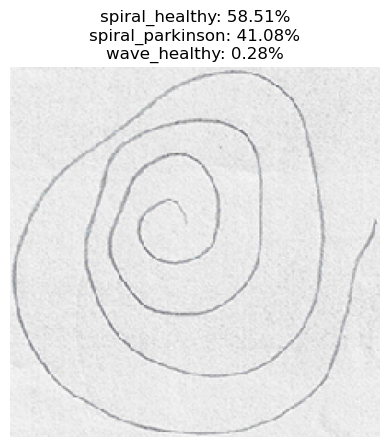

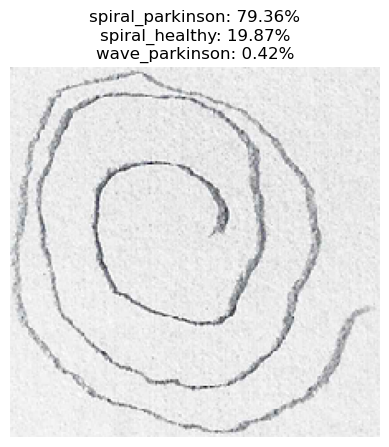

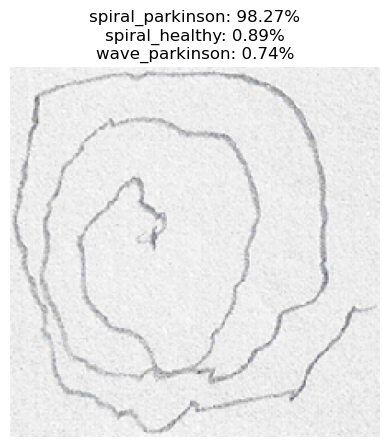

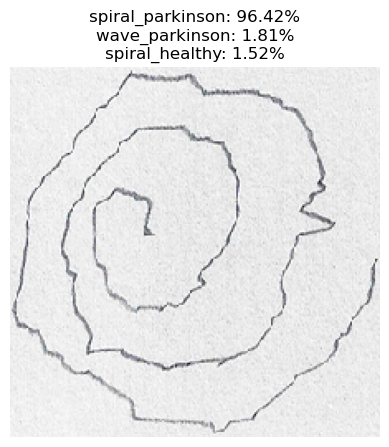

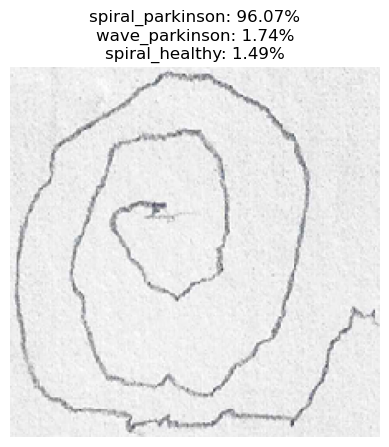

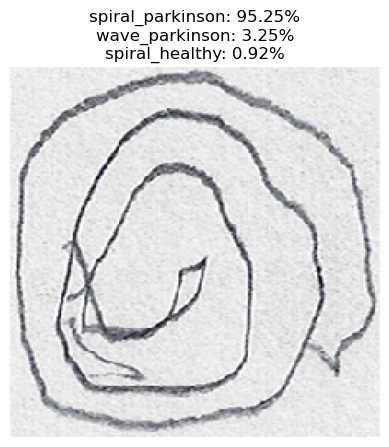

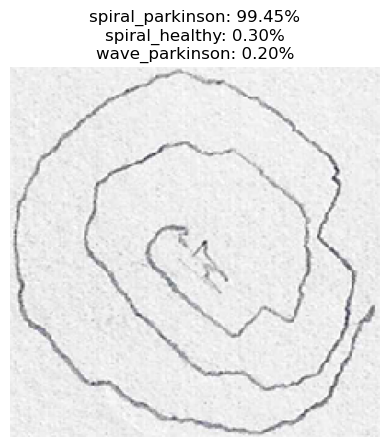

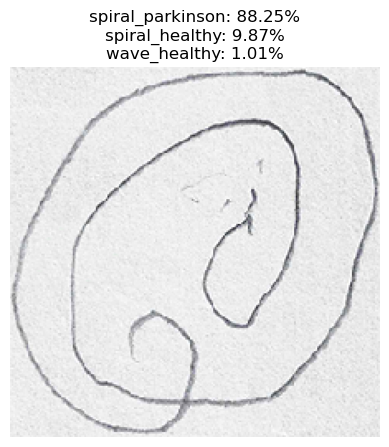

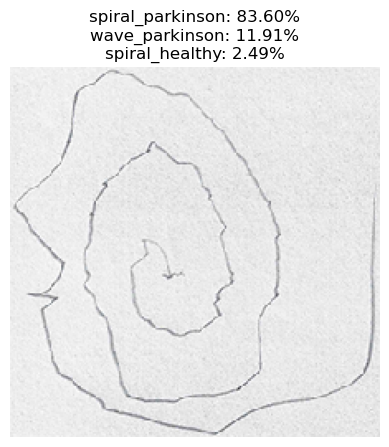

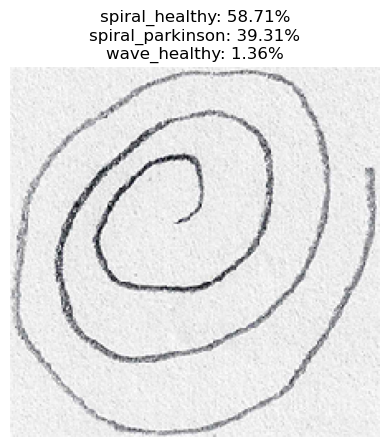

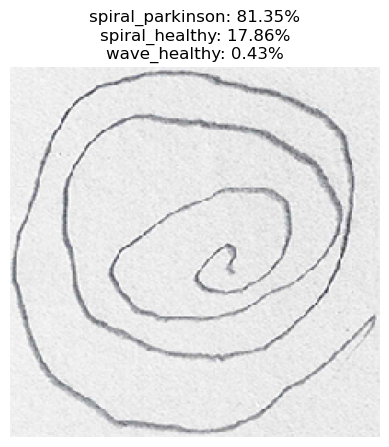

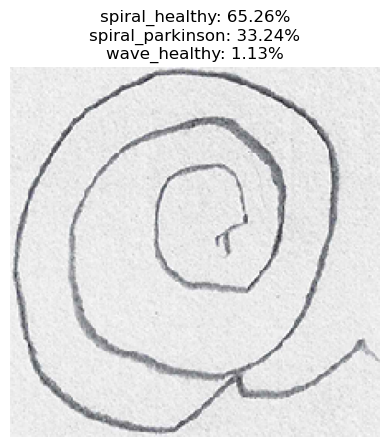

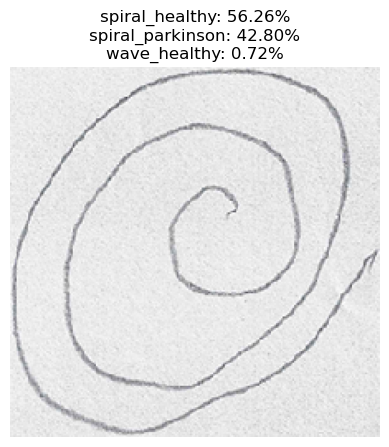

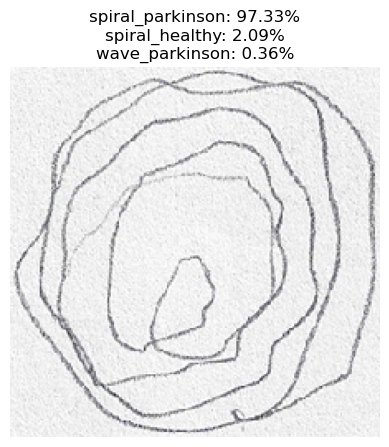

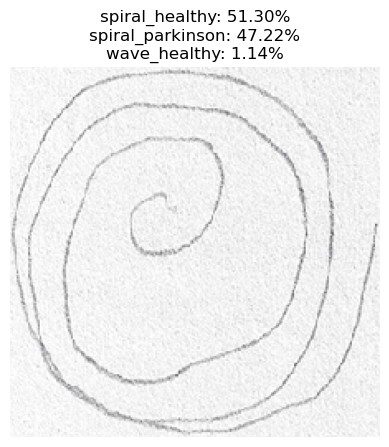

In [23]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os

# Load TFLite model
interpreter = tf.lite.Interpreter(model_path="netv2_model.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Preprocessing settings
IMG_SIZE = (224, 224)
CLASS_NAMES = ['spiral_healthy', 'spiral_parkinson', 'wave_healthy', 'wave_parkinson']

# Folder containing images
image_folder = "drawings_separated/test/spiral_parkinson"

for img_file in os.listdir(image_folder):
    img_path = os.path.join(image_folder, img_file)
    
    if not img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
        continue  # skip non-image files
    
    # Load image
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img).astype(np.float32)
    img_array = np.expand_dims(img_array, axis=0)  # shape (1, 224, 224, 3)
    
    # Set input tensor
    interpreter.set_tensor(input_details[0]['index'], img_array)
    
    # Run inference
    interpreter.invoke()
    
    # Get output prediction
    predictions = interpreter.get_tensor(output_details[0]['index'])[0]  # remove batch dimension
    
    # Get top 3 predictions
    top_indices = predictions.argsort()[-3:][::-1]
    top_classes = [CLASS_NAMES[i] for i in top_indices]
    top_confidences = [predictions[i] for i in top_indices]
    
    # Display result
    plt.imshow(img)
    title_text = "\n".join([f"{c}: {conf*100:.2f}%" for c, conf in zip(top_classes, top_confidences)])
    plt.title(title_text)
    plt.axis('off')
    plt.show()


Convert to tflite

In [21]:
import tensorflow as tf

# Load your saved Keras model
model = tf.keras.models.load_model("netv2_model_initial.keras")

# Converter
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# (Optional) Enable optimizations for smaller + faster model
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert
tflite_model = converter.convert()

# Save the TFLite file
with open("netv2_model.tflite", "wb") as f:
    f.write(tflite_model)

print("Converted successfully!")


c:\Users\Felix\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 4 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


INFO:tensorflow:Assets written to: C:\Users\Felix\AppData\Local\Temp\tmp0rzlrmu3\assets


INFO:tensorflow:Assets written to: C:\Users\Felix\AppData\Local\Temp\tmp0rzlrmu3\assets


Saved artifact at 'C:\Users\Felix\AppData\Local\Temp\tmp0rzlrmu3'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_4')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  2365192456912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2365192463440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2365192463632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2365192459216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2365192456720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2365192463824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2365192459024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2365192469968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2365192458448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2365192456144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2365

#### BEST WITH AUGMENTATION = 0.8472

In [13]:
netv2_model.save("netv2_model_initial.keras")

further training because I think model hasn't converged

In [5]:
len(history.history['loss'])

100

### TRAINING

In [8]:
# Unfreeze the base model
base_model.trainable = True

# Optionally, freeze first few layers to preserve low-level features
fine_tune_at = 100  # adjust based on layer depth
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Compile again with a lower learning rate for fine-tuning
netv2_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # smaller LR
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Fine-tune
fine_tune_history = netv2_model.fit(
    test_ds,
    validation_data=train_ds,
    epochs=50,  # set how many fine-tuning epochs you want
    callbacks=callbacks
)


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.4412 - loss: 1.2847 - val_accuracy: 0.8542 - val_loss: 0.3754 - learning_rate: 1.0000e-05
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.5098 - loss: 1.2378 - val_accuracy: 0.8611 - val_loss: 0.3790 - learning_rate: 1.0000e-05
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.5490 - loss: 1.0385 - val_accuracy: 0.8542 - val_loss: 0.3823 - learning_rate: 1.0000e-05
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.6029 - loss: 0.9154 - val_accuracy: 0.8333 - val_loss: 0.3862 - learning_rate: 1.0000e-05
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.6422 - loss: 0.8435 - val_accuracy: 0.8264 - val_loss: 0.3903 - learning_rate: 1.0000e-05
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.6373 - loss: 0.8013 - val_accuracy: 0.8264 - val_loss: 0.3912 - learning_rate: 5.0000e-06
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.7059 - loss: 0.7437 - val_

In [40]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Paths
train_dir = "drawings_combined/train"
test_dir = "drawings_combined/test"

# Image size and batch
IMG_SIZE = (128, 128)  # Small images for drawings
BATCH_SIZE = 16

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# Small CNN model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    MaxPooling2D(2,2),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # 4 classes
])

# Compile
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=test_generator,
    callbacks=[early_stop, reduce_lr]
)


Found 144 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


c:\Users\Felix\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Felix\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 421ms/step - accuracy: 0.4792 - loss: 0.8758 - val_accuracy: 0.5000 - val_loss: 0.6935 - learning_rate: 0.0010
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 340ms/step - accuracy: 0.4861 - loss: 0.6998 - val_accuracy: 0.5000 - val_loss: 0.6979 - learning_rate: 0.0010
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 369ms/step - accuracy: 0.5417 - loss: 0.7108 - val_accuracy: 0.5000 - val_loss: 0.7134 - learning_rate: 0.0010
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 338ms/step - accuracy: 0.4861 - loss: 0.6975 - val_accuracy: 0.5000 - val_loss: 0.6933 - learning_rate: 0.0010
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 346ms/step - accuracy: 0.4931 - loss: 0.6944 - val_accuracy: 0.5000 - val_loss: 0.6933 - learning_rate: 0.0010
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 338ms/step - accuracy: 0.5139 - loss: 0.6924 - val_accuracy: 0.5000 - val_loss: 0.6945 - learning_rate: 0.0010
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 331ms/step - accuracy: 0.4375 - loss: 0.7015 - val_accuracy: 

In [27]:
import os
import cv2
import numpy as np
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import VotingClassifier

# --- Paths ---
dataset_dir = "drawings_separated"  # contains train/test folders
classes = ["spiral_healthy", "spiral_parkinson", "wave_healthy", "wave_parkinson"]

# --- Parameters ---
IMG_SIZE = (128, 128)  # resize images
orientations = 9
pixels_per_cell = (8, 8)
cells_per_block = (2, 2)

# --- Function to load images and extract HOG features ---
def load_images_hog(folder_path):
    features = []
    labels = []
    for cls in classes:
        cls_path = os.path.join(folder_path, cls)
        if not os.path.exists(cls_path):
            continue
        for fname in os.listdir(cls_path):
            img_path = os.path.join(cls_path, fname)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, IMG_SIZE)
            # Compute HOG features
            hog_feat = hog(img,
                           orientations=orientations,
                           pixels_per_cell=pixels_per_cell,
                           cells_per_block=cells_per_block,
                           block_norm='L2-Hys')
            features.append(hog_feat)
            labels.append(cls)
    return np.array(features), np.array(labels)

# --- Load dataset ---
print("Loading training data...")
X_train, y_train = load_images_hog(os.path.join(dataset_dir, "train"))
print("Loading testing data...")
X_test, y_test = load_images_hog(os.path.join(dataset_dir, "test"))

# --- Encode labels ---
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# --- Define individual classifiers ---
svm_clf = SVC(kernel='linear', probability=True, random_state=42)
dt_clf = DecisionTreeClassifier(max_depth=5, random_state=42)
xgb_clf = XGBClassifier(n_estimators=200, max_depth=4, learning_rate=0.1,
                        use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# --- Combine into VotingClassifier with more weight to XGBoost ---
voting_clf = VotingClassifier(
    estimators=[('svm', svm_clf), ('xgb', xgb_clf)],
    voting='soft',           # use probabilities
    weights=[1, 2]        # give 3x weight to XGBoost
)

# --- Train ensemble ---
voting_clf.fit(X_train, y_train_enc)

# --- Evaluate ---
y_pred = voting_clf.predict(X_test)
print("Classification Report:\n", classification_report(y_test_enc, y_pred, target_names=le.classes_))
print("Confusion Matrix:\n", confusion_matrix(y_test_enc, y_pred))


Loading training data...
Loading testing data...


c:\Users\Felix\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [21:09:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report:
                   precision    recall  f1-score   support

  spiral_healthy       0.81      0.87      0.84        15
spiral_parkinson       0.86      0.80      0.83        15
    wave_healthy       0.67      0.80      0.73        15
  wave_parkinson       0.75      0.60      0.67        15

        accuracy                           0.77        60
       macro avg       0.77      0.77      0.77        60
    weighted avg       0.77      0.77      0.77        60

Confusion Matrix:
 [[13  2  0  0]
 [ 3 12  0  0]
 [ 0  0 12  3]
 [ 0  0  6  9]]


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 4

# Directories
train_dir = "drawings_separated/train"
test_dir = "drawings_separated/test - Copy"

# Load datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=True
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=False
)

# Normalize pixel values to [0,1]
normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

# Data augmentation (optional but helpful)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)




Found 144 files belonging to 4 classes.
Found 204 files belonging to 4 classes.


In [49]:
# Build smaller CNN
cnn_model = models.Sequential([
    layers.InputLayer(input_shape=(224, 224, 3)),

    # Block 1
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    # Block 2
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    # Block 3
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    # Fully connected
    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

cnn_model.summary()

# Compile model
cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
]

# Train model
history = cnn_model.fit(
    train_ds,
    validation_data=train_ds,
    epochs=50,
    callbacks=callbacks
)

c:\Users\Felix\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,011,684 (99.23 MB)

 Trainable params: 26,011,236 (99.22 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 44s 8s/step - accuracy: 0.2847 - loss: 2.3804 - val_accuracy: 0.2500 - val_loss: 1.4546 - learning_rate: 1.0000e-04
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 38s 8s/step - accuracy: 0.3264 - loss: 1.8299 - val_accuracy: 0.2500 - val_loss: 1.4567 - learning_rate: 1.0000e-04
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 40s 8s/step - accuracy: 0.5139 - loss: 1.2070 - val_accuracy: 0.2500 - val_loss: 1.4568 - learning_rate: 1.0000e-04
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 46s 9s/step - accuracy: 0.5625 - loss: 1.0660 - val_accuracy: 0.3403 - val_loss: 1.4590 - learning_rate: 1.0000e-04
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 40s 8s/step - accuracy: 0.5625 - loss: 1.0225 - val_accuracy: 0.2500 - val_loss: 1.4626 - learning_rate: 1.0000e-04
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 39s 8s/step - accuracy: 0.6667 - loss: 0.8502 - val_accuracy: 0.2500 - val_loss: 1.4822 - learning_rate: 1.0000e-04
Epoch 7/50


KeyboardInterrupt: 